# Summary

Extract SCOPe ids from the training, validation, and test subsets of our training data.

1. Compare the overlap of domains from these three sources:

    - `scop95_01Mar17.tgz`, `scop90_01Mar17.tgz`, `scop70_01Mar17.tgz`, `scop40_01Mar17.tgz` from the hh-suite [downloads page](http://wwwuser.gwdg.de/~compbiol/data/hhsuite/databases/hhsuite_dbs/).
    - Files downloaded from the SCOPe website.

    ```bash
    rg --text '\0' scop95_a3m.ffdata | wc -l
    ```

2. Get CATH/Gene3d domains from the PAGNN training set that correspond to different SCOP domains.

----

# Imports

In [139]:
import os
import subprocess
import shlex
import io
import re
import itertools
from pathlib import Path
from pprint import pprint
from IPython.display import display

In [57]:
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

In [58]:
pd.set_option('display.max_columns', 1000)

In [59]:
%matplotlib inline

# Parameters

In [60]:
NOTEBOOK_PATH = Path(os.getenv('OUTPUT_DIR', '.')).joinpath('scop_dataset').resolve()
NOTEBOOK_PATH.mkdir(parents=True, exist_ok=True)
NOTEBOOK_PATH

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/datapkg/adjacency-net/notebooks/scop_dataset')

In [61]:
DATA_PATH = Path(os.environ['DATA_DIR']).resolve()
DATA_PATH

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/database_data')

In [62]:
DATABIN_PATH = Path(os.environ['DATABIN_DIR']).resolve()
DATABIN_PATH

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/databin')

# Spark

In [63]:
import pyspark
from pyspark.sql import SparkSession

In [64]:
os.environ['JAVA_HOME']

'/home/p/pmkim/strokach/anaconda3'

In [65]:
!ls /home/p/pmkim/strokach/anaconda3

bin		       include	    mysql	 ssl
compiler_compat        jre	    phrasebooks  translations
conda-meta	       lib	    pkgs	 var
data		       libexec	    plugins	 vscode_inst.py.log
doc		       LICENSE	    qml		 x86_64-conda_cos6-linux-gnu
envs		       LICENSE.txt  README
etc		       man	    scripts
hhsuite-userguide.pdf  mkspecs	    share


In [66]:
cpu_count = psutil.cpu_count()

spark = (
    SparkSession
    .builder
    .master(f"local[{cpu_count}]")
    .appName(NOTEBOOK_PATH.name)
    .config('spark.driver.memory', '80G')  # Controls both -Xmx and spark.driver.memory
    .config('spark.executor.memory', '120g')
    .config('spark.memory.storageFraction', 0)
#     .config('spark.driver.maxResultSize', '10G')
    .getOrCreate()
)

In [67]:
spark

# Functions

In [68]:
print(re.findall('(-?\d+)-(-?\d+)', '1-10'))
print(re.findall('(-?\d+)-(-?\d+)', '-1-10'))
print(re.findall('(-?\d+)-(-?\d+)', '-1--10'))
print(re.findall('(-?\d+)-(-?\d+)', '1--10'))
print()

[('1', '10')]
[('-1', '10')]
[('-1', '-10')]
[('1', '-10')]



In [69]:
def parse_scop_header(header):
    columns = [
        'scop_id', 'scop_family', 'pdb_chain', 'pdb_domain_range',
        'protein_name', 'organism_name',
    ]
    match = re.findall(
        '^>(.*) ([a-z]\.\d+\.\d+\.\d+) \((.*):(.*?)\) ([^{}]*) {(.*)}$',
        header)
    if not match:
        raise Exception(f"Could not parser header: {header}")
    data = dict(zip(columns, match[0]))
    data['pdb_id'] = data['scop_id'][1:5].upper()
    domain_range = re.findall('(-?\d+)-(-?\d+)', data['pdb_domain_range'])
    if domain_range:
        data['pdb_domain_start'], data['pdb_domain_end'] = map(int, domain_range[0])
    else:
        data['pdb_domain_start'], data['pdb_domain_end'] = None, None
#     data['scop_id'] = data['scop_id'] + data['pdb_chain'] + data['pdb_chain_range']
    return data
    

header = ">d1q90l_ f.23.24.1 (L:) PetL subunit of the cytochrome b6f complex {Green alga (Chlamydomonas reinhardtii) [TaxId: 3055]}"
pprint(parse_scop_header(header))

header = ">d2cmyb1 g.2.4.1 (B:7-29) Trypsin inhibitor VhTI {Veronica hederifolia [TaxId: 202477]}"
pprint(parse_scop_header(header))

header = ">d1f93h_ a.34.2.1 (H:) Hepatocyte nuclear factor 1 (HNF-1), N-terminal domain {Mouse (Mus musculus) [TaxId: 10090]}"
pprint(parse_scop_header(header))

header = ">d1ag7a_ g.3.6.1 (A:) Conotoxin {Synthetic, based on Conus geographus, GS}"
pprint(parse_scop_header(header))

{'organism_name': 'Green alga (Chlamydomonas reinhardtii) [TaxId: 3055]',
 'pdb_chain': 'L',
 'pdb_domain_end': None,
 'pdb_domain_range': '',
 'pdb_domain_start': None,
 'pdb_id': '1Q90',
 'protein_name': 'PetL subunit of the cytochrome b6f complex',
 'scop_family': 'f.23.24.1',
 'scop_id': 'd1q90l_'}
{'organism_name': 'Veronica hederifolia [TaxId: 202477]',
 'pdb_chain': 'B',
 'pdb_domain_end': 29,
 'pdb_domain_range': '7-29',
 'pdb_domain_start': 7,
 'pdb_id': '2CMY',
 'protein_name': 'Trypsin inhibitor VhTI',
 'scop_family': 'g.2.4.1',
 'scop_id': 'd2cmyb1'}
{'organism_name': 'Mouse (Mus musculus) [TaxId: 10090]',
 'pdb_chain': 'H',
 'pdb_domain_end': None,
 'pdb_domain_range': '',
 'pdb_domain_start': None,
 'pdb_id': '1F93',
 'protein_name': 'Hepatocyte nuclear factor 1 (HNF-1), N-terminal domain',
 'scop_family': 'a.34.2.1',
 'scop_id': 'd1f93h_'}
{'organism_name': 'Synthetic, based on Conus geographus, GS',
 'pdb_chain': 'A',
 'pdb_domain_end': None,
 'pdb_domain_range': '',
 '

In [70]:
def get_scop_domains_from_ffdata(filepath):
    assert filepath.suffix == '.ffdata'

    proc1 = subprocess.run(
        shlex.split(f"head -n1 {filepath}"),
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    if proc1.stderr.strip():
        print("proc1 stderr:")
        print(proc1.stderr.strip())

    proc2 = subprocess.run(
        shlex.split(f"rg --text '\\0' {filepath}"),
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    if proc2.stderr.strip():
        print("proc2 stderr:")
        print(proc2.stderr.strip())

    data = []
    for i, line in enumerate(itertools.chain(
            proc1.stdout.strip().split('\n'), proc2.stdout.strip().split('\n'))):
        line = line.replace('\0', '')
        if not line:
            print(f"Skipping line: {i}")
            continue
        data.append(parse_scop_header(line))

    df = pd.DataFrame(data)

    df_ref = pd.read_csv(
        filepath.with_suffix('.ffindex'), sep='\t', names=['scop_id', 'start', 'length'])
    assert (df['scop_id'].values == df_ref.sort_values('start')['scop_id'].values).all()

    return df


df = get_scop_domains_from_ffdata(DATA_PATH / 'hh-suite' / 'scop95_01Mar17' / 'scop95_a3m.ffdata')
df.head()

Skipping line: 9357


,organism_name,pdb_chain,pdb_domain_end,pdb_domain_range,pdb_domain_start,pdb_id,protein_name,scop_family,scop_id
0,Escherichia coli K-12 [TaxId: 83333],A,251.0,232-251,232.0,4AA7,automated matches,c.68.1.0,d4aa7a1
1,Mouse mammary tumor virus [TaxId: 11757],A,NaN,,NaN,1DSQ,Nucleic acid binding protein p14,g.40.1.1,d1dsqa_
2,Human (Homo sapiens) [TaxId: 9606],N,NaN,,NaN,1OQD,Tumor necrosis factor receptor superfamily mem...,g.24.1.2,d1oqdn_
3,Trypanosome (Trypanosoma brucei) [TaxId: 5691],B,NaN,,NaN,2CIO,automated matches,b.1.26.0,d2ciob_
4,Scorpion (Tityus cambridgei) [TaxId: 184226],A,NaN,,NaN,1JLZ,"alpha-KTX, K+-channel blocker",g.3.7.2,d1jlza_


In [71]:
def get_scop_domains_from_fasta(filepath):
    assert filepath.suffix == '.fa'

    proc = subprocess.run(
        shlex.split(f"rg --text '^>' {filepath}"),
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
    if proc.stderr.strip():
        print("proc stderr:")
        print(proc.stderr.strip())
        
    data = []
    for i, line in enumerate(proc.stdout.strip().split('\n')):
        if not line:
            print(f"Skipping line: {i}")
            continue
        data.append(parse_scop_header(line))

    df = pd.DataFrame(data)

    df_ref = pd.read_csv(filepath.with_suffix('.id'), names=['scop_id'])
    assert not (set(df['scop_id']) ^ set(df_ref['scop_id']))

    return df


df = get_scop_domains_from_fasta(
    DATA_PATH / 'scop' / 'v2.07' / 'astral-scopedom-seqres-gd-sel-gs-bib-100-2.07.fa')
df.head()

,organism_name,pdb_chain,pdb_domain_end,pdb_domain_range,pdb_domain_start,pdb_id,protein_name,scop_family,scop_id
0,Bacillus subtilis [TaxId: 1423],A,NaN,,NaN,1UX8,Protozoan/bacterial hemoglobin,a.1.1.1,d1ux8a_
1,Ciliate (Paramecium caudatum) [TaxId: 5885],A,NaN,,NaN,1DLW,Protozoan/bacterial hemoglobin,a.1.1.1,d1dlwa_
2,Green alga (Chlamydomonas eugametos) [TaxId: 3...,A,NaN,,NaN,1DLY,Protozoan/bacterial hemoglobin,a.1.1.1,d1dlya_
3,"Mycobacterium tuberculosis, HbN [TaxId: 1773]",A,NaN,,NaN,2GKM,Protozoan/bacterial hemoglobin,a.1.1.1,d2gkma_
4,"Mycobacterium tuberculosis, HbN [TaxId: 1773]",B,NaN,,NaN,2GKM,Protozoan/bacterial hemoglobin,a.1.1.1,d2gkmb_


# Databases

In [72]:
!ls {DATA_PATH}

hh-suite  scop


## `hh-suite`

In [73]:
!ls {DATA_PATH}/hh-suite

pdb70_from_mmcif_180523  scop70_01Mar17  scop90_01Mar17  uniprot20_2016_02
scop40_01Mar17		 scop70_1.75	 scop95_01Mar17


In [74]:
hhsuite_dfs = {}

for scop_version in ['01Mar17', ]:  # '1.75'
    for sic in {'01Mar17': [40, 70, 90, 95], '1.75': [70]}[scop_version]:
        print(scop_version, sic)
        filepath = (
            DATA_PATH
            .joinpath(f'hh-suite')
            .joinpath(f'scop{sic}_{scop_version}')
            .joinpath(f'scop{sic}_a3m.ffdata'))
        print(filepath, flush=True)
        df = get_scop_domains_from_ffdata(filepath)
        df['scop_version'] = scop_version
        df['seq_identity_cutoff'] = sic
        hhsuite_dfs[(scop_version, sic)] = df

01Mar17 40
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/hh-suite/scop40_01Mar17/scop40_a3m.ffdata
Skipping line: 2844
01Mar17 70
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/hh-suite/scop70_01Mar17/scop70_a3m.ffdata
Skipping line: 4408
01Mar17 90
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/hh-suite/scop90_01Mar17/scop90_a3m.ffdata
Skipping line: 6377
01Mar17 95
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/hh-suite/scop95_01Mar17/scop95_a3m.ffdata
Skipping line: 9357


In [75]:
hhsuite_dfs.keys()

dict_keys([('01Mar17', 40), ('01Mar17', 70), ('01Mar17', 90), ('01Mar17', 95)])

In [76]:
columns = [
    'scop_version', 'seq_identity_cutoff', 
    'num_domains', 'num_unique_domains', 'scop_domains',
    'num_families', 'scop_families'
]

hhsuite_stats = pd.DataFrame(
    data=[
        (scop_version, seq_identity_cutoff, 
         len(df), len(set(df['scop_id'])), set(df['scop_id']),
         len(set(df['scop_family'])), set(df['scop_family']), 
        )
         for scop_version in ['01Mar17']
         for seq_identity_cutoff in [40, 70, 90, 95]
         for df in [hhsuite_dfs[(scop_version, seq_identity_cutoff)]]
    ],
    columns=columns,
)
assert (hhsuite_stats['num_domains'] == hhsuite_stats['num_unique_domains']).all()
del hhsuite_stats['num_unique_domains']
hhsuite_stats

,scop_version,seq_identity_cutoff,num_domains,scop_domains,num_families,scop_families
0,01Mar17,40,2844,"{d1dqca_, d1vr8a1, d2ysca1, d1j8ca_, d4eo1a_, ...",1496,"{b.40.4.12, b.106.1.2, f.23.27.1, g.50.1.3, b...."
1,01Mar17,70,4408,"{d1dqca_, d3hg0c1, d1vr8a1, d2ysca1, d1j8ca_, ...",1909,"{a.139.1.1, b.47.1.2, b.40.4.12, b.106.1.2, f...."
2,01Mar17,90,6377,"{d3hg0c1, d1p3ja1, d2ysca1, d1nxca_, d1qjta_, ...",2223,"{a.139.1.1, b.47.1.2, b.40.4.12, b.106.1.2, f...."
3,01Mar17,95,9357,"{d3hg0c1, d3ke5c_, d1p3ja1, d2ysca1, d1clol1, ...",2534,"{a.139.1.1, b.47.1.2, b.40.4.12, b.106.1.2, f...."


In [77]:
schema = None

for (version, sic), df in hhsuite_dfs.items():
    filepath = NOTEBOOK_PATH.joinpath(f"scop-hhsuite-{version}-{sic}.parquet")
    if schema is None:
        table = pa.Table.from_pandas(df, preserve_index=False)
        for column_name in ['pdb_domain_start', 'pdb_domain_end']:
            idx = table.schema.get_field_index(column_name)
            column = table.column(idx).cast(pa.int32())
            table = table.remove_column(idx).add_column(idx, column)
        schema = table.schema
    else:
        table = pa.Table.from_pandas(df, schema=schema, preserve_index=False)
    pq.write_table(pa.Table.from_pandas(df), filepath, flavor='spark')

## `scop`

In [78]:
!ls {DATA_PATH}/scop

v1.75  v2.07


In [79]:
scop_dfs = {}

for scop_version in ['1.75', '2.07']:
    scop_name = 'scop' if float(scop_version) < 2 else 'scope'
    print(scop_name, scop_version)
    for sic in [10, 20, 25, 30, 35, 40, 50, 70, 90, 95, 100]:
        filepath = (
            DATA_PATH
            .joinpath(f'scop')
            .joinpath(f'v{scop_version}')
            .joinpath(f'astral-{scop_name}dom-seqres-gd-sel-gs-bib-{sic}-{scop_version}.fa'))
        print(filepath, flush=True)
        df = get_scop_domains_from_fasta(filepath)
        df['scop_version'] = f"{scop_name} v{scop_version}"
        df['seq_identity_cutoff'] = sic
        scop_dfs[(scop_version, sic)] = df

scop 1.75
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-10-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-20-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-25-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-30-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-35-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-50-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-70-1.75.fa
/gpfs/fs0/scratch/p/pmkim/strokach/database_data/scop/v1.75/astral-scopdom-seqres-gd-sel-gs-bib-90-1.75.fa
/gpfs/fs0/scratch/p/pmkim/s

In [80]:
scop_dfs.keys()

dict_keys([('1.75', 10), ('1.75', 20), ('1.75', 25), ('1.75', 30), ('1.75', 35), ('1.75', 40), ('1.75', 50), ('1.75', 70), ('1.75', 90), ('1.75', 95), ('1.75', 100), ('2.07', 10), ('2.07', 20), ('2.07', 25), ('2.07', 30), ('2.07', 35), ('2.07', 40), ('2.07', 50), ('2.07', 70), ('2.07', 90), ('2.07', 95), ('2.07', 100)])

In [81]:
columns = [
    'scop_version', 'seq_identity_cutoff', 
    'num_domains', 'num_unique_domains', 'scop_domains',
    'num_families', 'scop_families'
]

scop_stats = pd.DataFrame(
    data=[
        (scop_version, seq_identity_cutoff, 
         len(df), len(set(df['scop_id'])), set(df['scop_id']),
         len(set(df['scop_family'])), set(df['scop_family']), 
        )
         for scop_version in ['1.75', '2.07']
         for seq_identity_cutoff in [10, 20, 25, 30, 35, 40, 50, 70, 90, 95, 100]
         for df in [scop_dfs[(scop_version, seq_identity_cutoff)]]
    ],
    columns=columns,
)
assert (scop_stats['num_domains'] == scop_stats['num_unique_domains']).all()
del scop_stats['num_unique_domains']
scop_stats

,scop_version,seq_identity_cutoff,num_domains,scop_domains,num_families,scop_families
0,1.75,10,6258,"{d1bs0a_, d2ghfa1, d1k4ta2, d1z84a1, d1ojra_, ...",3749,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
1,1.75,20,7002,"{d1bs0a_, d2ghfa1, d1k4ta2, d1z84a1, d1lqaa_, ...",3852,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
2,1.75,25,7797,"{d1bs0a_, d2ghfa1, d1vlba4, d1k4ta2, d1z84a1, ...",3876,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
3,1.75,30,8792,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1vlba4, ...",3889,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
4,1.75,35,9750,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1vlba4, ...",3895,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
5,1.75,40,10569,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1vlba4, ...",3898,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
6,1.75,50,11915,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1vlba4, ...",3900,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
7,1.75,70,13734,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1rw0a_, ...",3900,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
8,1.75,90,15545,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1ai1l1, ...",3901,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."
9,1.75,95,16712,"{d1bs0a_, d1w5sa1, d1snya_, d2ghfa1, d1ai1l1, ...",3901,"{a.139.1.1, b.47.1.2, c.124.1.3, b.40.4.12, b...."


In [82]:
for (version, sic), df in scop_dfs.items():
    filepath = NOTEBOOK_PATH.joinpath(f"scop-astral-{version}-{sic}.parquet")
    if schema is None:
        table = pa.Table.from_pandas(df, preserve_index=False)
        for column_name in ['pdb_domain_start', 'pdb_domain_end']:
            idx = table.schema.get_field_index(column_name)
            column = table.column(idx).cast(pa.int32())
            table = table.remove_column(idx).add_column(idx, column)
        schema = table.schema
    else:
        table = pa.Table.from_pandas(df, schema=schema, preserve_index=False)
    pq.write_table(pa.Table.from_pandas(df), filepath, flavor='spark')

## Summary

In [83]:
# overlap_scop_df
overlap_scop_df = (
    scop_stats[scop_stats['scop_version'] == '1.75']
    .merge(scop_stats[scop_stats['scop_version'] == '2.07'], on='seq_identity_cutoff', suffixes=('_1', '_2'))
)

overlap_scop_df['num_domains'] = (
    overlap_scop_df.apply(lambda r: len(r['scop_domains_1'] & r['scop_domains_2']), axis=1)
)

overlap_scop_df['num_families'] = (
    overlap_scop_df.apply(lambda r: len(r['scop_families_1'] & r['scop_families_2']), axis=1)
)

overlap_scop_df['scop_version'] = 'Overlap 1.75 & 2.07'

In [84]:
# overlap_all_df
overlap_all_df = (
    scop_stats[scop_stats['scop_version'] == '1.75']
    .merge(scop_stats[scop_stats['scop_version'] == '2.07'], on='seq_identity_cutoff', suffixes=('_1', '_2'))
    .merge(hhsuite_stats[hhsuite_stats['scop_version'] == '01Mar17'], on='seq_identity_cutoff')
)

overlap_all_df['num_domains'] = (
    overlap_all_df.apply(lambda r: len(r['scop_domains_2'] & r['scop_domains']), axis=1)
)

overlap_all_df['num_families'] = (
    overlap_all_df.apply(lambda r: len(r['scop_families_2'] & r['scop_families']), axis=1)
)

overlap_all_df['scop_version'] = 'Overlap 2.07 & 01Mar17'

In [85]:
plot_df = pd.concat([
    scop_stats[['scop_version', 'seq_identity_cutoff', 'num_domains', 'num_families']],
    overlap_scop_df[['scop_version', 'seq_identity_cutoff', 'num_domains', 'num_families']],
    hhsuite_stats[['scop_version', 'seq_identity_cutoff', 'num_domains', 'num_families']],
    overlap_all_df[['scop_version', 'seq_identity_cutoff', 'num_domains', 'num_families']],
])

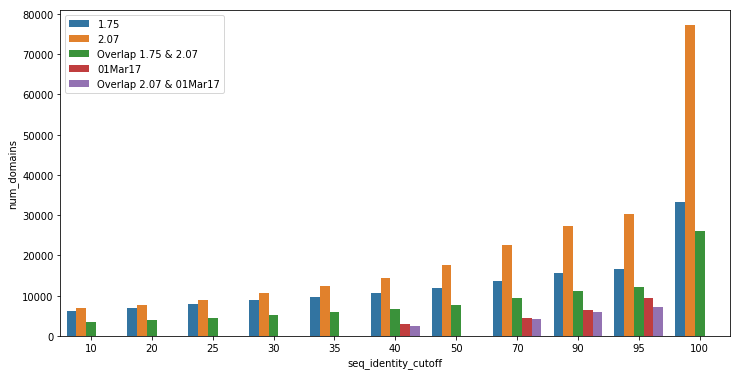

In [132]:
with plt.rc_context({'figure.figsize': (12, 6), 'legend.loc': 'upper left', 'savefig.bbox': 'tight'}):
    ax = sns.barplot(x="seq_identity_cutoff", y="num_domains", hue="scop_version", data=plot_df)
    plt.legend()
    plt.savefig(NOTEBOOK_PATH.joinpath('scop_num_domains.png').as_posix(), dpi=300)

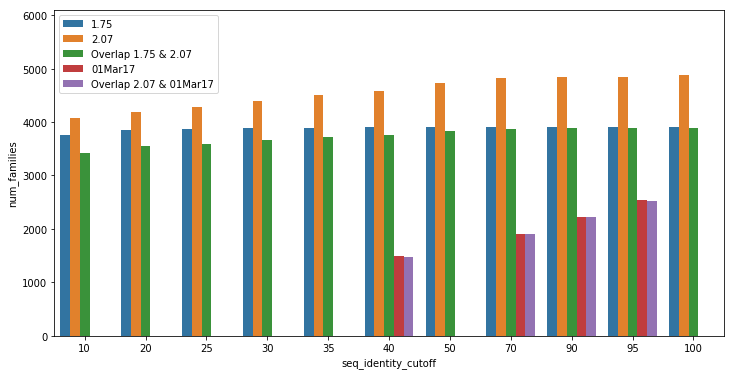

In [130]:
with plt.rc_context({'figure.figsize': (12, 6), 'legend.loc': 'upper left', 'savefig.bbox': 'tight'}):
    ax = sns.barplot(x="seq_identity_cutoff", y="num_families", hue="scop_version", data=plot_df)
    plt.ylim(0, 6100)
    plt.legend()
    plt.savefig(NOTEBOOK_PATH.joinpath('scop_num_families.png').as_posix(), dpi=300)

# Map to training / validation / test datasets

### `scop-hhsuite-01Mar17-40.parquet`

In [88]:
ds = spark.sql(f"""\
select *
from parquet.`{NOTEBOOK_PATH}/scop-hhsuite-01Mar17-40.parquet` s
limit 10
""")

In [89]:
df = ds.toPandas()

In [90]:
df.head(2)

,organism_name,pdb_chain,pdb_domain_end,pdb_domain_range,pdb_domain_start,pdb_id,protein_name,scop_family,scop_id,scop_version,seq_identity_cutoff,__index_level_0__
0,Escherichia coli K-12 [TaxId: 83333],A,251.0,232-251,232.0,4AA7,automated matches,c.68.1.0,d4aa7a1,01Mar17,40,0
1,Mouse mammary tumor virus [TaxId: 11757],A,NaN,,NaN,1DSQ,Nucleic acid binding protein p14,g.40.1.1,d1dsqa_,01Mar17,40,1


In [133]:
hhsuite_dfs.keys()

dict_keys([('01Mar17', 40), ('01Mar17', 70), ('01Mar17', 90), ('01Mar17', 95)])

In [135]:
hhsuite_dfs[('01Mar17', 40)].shape

(2844, 11)

### `adjacency_matrix.parquet`

#### Notes:

- 290,384 domains in in `adjacency_matrix.parquet` map to a PDB chain with 100% sequence identity.

In [91]:
ds = spark.sql(f"""\
select *
from parquet.`{DATABIN_PATH}/uniparc_domain/0.1/adjacency_matrix.parquet` am
where am.pc_identity = 100
limit 10
""")

In [92]:
df = ds.toPandas()

In [93]:
df.head(2)

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected,database_id
0,UPI00098639D7,AAIAYGADEVDVVFPYRALMAGNEQVGFDLVKACKEACAAANVLLK...,Gene3D,Aldolase-type TIM barrel,IPR013785,1,161,123950722,161,1JCL,0.0,A,100.0,160.0,0.0,0.0,1.0,160.0,93.0,252.0,-110.522879,322.0,AAIAYGADEVDVVFPYRALMAGNEQVGFDLVKACKEACAAANVLLK...,AAIAYGADEVDVVFPYRALMAGNEQVGFDLVKACKEACAAANVLLK...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[92.0, 92.0, 92.0, 92.0, 93.0, 93.0, 93.0, 93....","[93.0, 94.0, 95.0, 96.0, 92.0, 94.0, 95.0, 96....","[93.0, 93.0, 93.0, 93.0, 94.0, 94.0, 94.0, 94....","[94.0, 95.0, 96.0, 97.0, 93.0, 95.0, 96.0, 97....","[A, A, A, A, A, A, A, A, A, A, A, I, I, I, I, ...","[A, I, A, Y, A, I, A, Y, G, A, V, A, A, A, Y, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 4.0, 0.0, 2.0, 3.0, 4.0, 5.0, ...",G3DSA:3.20.20.70
1,UPI0003D5BA9E,ADFGQEVADKVRVQYGGSVKPENVASYMACPDVDGALVGGASLEAE...,Gene3D,Aldolase-type TIM barrel,IPR013785,1,56,284687258,56,5IBX,0.0,A,100.0,55.0,0.0,0.0,1.0,55.0,196.0,250.0,-31.000000,112.0,ADFGQEVADKVRVQYGGSVKPENVASYMACPDVDGALVGGASLEAE...,ADFGQEVADKVRVQYGGSVKPENVASYMACPDVDGALVGGASLEAE...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[195.0, 195.0, 195.0, 196.0, 196.0, 196.0, 197...","[196.0, 197.0, 198.0, 195.0, 197.0, 198.0, 195...","[200.0, 200.0, 200.0, 201.0, 201.0, 201.0, 202...","[201.0, 202.0, 203.0, 200.0, 202.0, 203.0, 200...","[A, A, A, D, D, D, F, F, F, F, F, G, G, G, G, ...","[D, F, G, A, F, G, A, D, G, Q, V, A, D, F, Q, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, ...","[1.0, 2.0, 3.0, 0.0, 2.0, 3.0, 0.0, 1.0, 3.0, ...",G3DSA:3.20.20.70


### `scop` + `uniparc_domain`

In [137]:
ds = spark.sql(f"""\
SELECT
-- scop columns
s.scop_id, s.scop_family, s.pdb_id, s.pdb_chain, s.pdb_domain_start, s.pdb_domain_end,

-- adjacency_matrix columns
am.__index_level_0__ adjacency_matrix_idx, am.uniparc_id, am.database_id cath_id, 
am.alignment_length, am.q_start, am.q_end, am.s_start, am.s_end, am.qseq, am.sseq

from parquet.`{NOTEBOOK_PATH}/scop-hhsuite-01Mar17-40.parquet` s
join parquet.`{DATABIN_PATH}/uniparc_domain/0.1/adjacency_matrix.parquet` am ON (
    s.pdb_id = am.structure_id and s.pdb_chain = am.chain_id)

where am.pc_identity = 100
and (s.pdb_domain_start is null
    or (least(s.pdb_domain_end - s.pdb_domain_start, am.s_end - am.s_start) /
        (greatest(s.pdb_domain_end, am.s_end) - least(s.pdb_domain_start, am.s_start))) > 0.9 )
""")

In [138]:
out = (
    ds
    .write
    .format("parquet")
    .mode("overwrite")
    .save(NOTEBOOK_PATH.joinpath('scop-hhsuite-adjacency_matrix.parquet').as_posix())
)

### `scop` + `uniparc`

In [97]:
ds = spark.sql(f"""\
select *
from parquet.`{NOTEBOOK_PATH}/scop-hhsuite-01Mar17-40.parquet` s
join parquet.`{DATABIN_PATH}/uniparc_domain/0.1/adjacency_matrix.parquet` am ON (
    s.pdb_id = am.structure_id and s.pdb_chain = am.chain_id)
where am.pc_identity = 100
limit 10
""")

In [98]:
df = ds.toPandas()

In [99]:
df.head(2)

,organism_name,pdb_chain,pdb_domain_end,pdb_domain_range,pdb_domain_start,pdb_id,protein_name,scop_family,scop_id,scop_version,seq_identity_cutoff,__index_level_0__,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected,database_id
0,Escherichia coli [TaxId: 562],A,330.0,1-330,1.0,1PS9,"2,4-dienoyl-CoA reductase, N-terminal domain",c.1.4.1,d1ps9a1,01Mar17,40,2699,UPI000AAD51D5,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,Gene3D,Aldolase-type TIM barrel,IPR013785,1,71,251502347,71,1PS9,0.0,A,100.0,71.0,0.0,0.0,1.0,71.0,298.0,368.0,-44.30103,154.0,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[297.0, 297.0, 297.0, 297.0, 297.0, 297.0, 297...","[298.0, 299.0, 300.0, 301.0, 302.0, 303.0, 306...","[298.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298...","[299.0, 300.0, 301.0, 302.0, 303.0, 304.0, 307...","[I, I, I, I, I, I, I, L, L, L, L, L, L, L, L, ...","[L, S, R, G, D, A, V, I, S, R, G, D, A, D, M, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 0.0, 2.0, ...",G3DSA:3.20.20.70
1,Escherichia coli [TaxId: 562],A,627.0,466-627,466.0,1PS9,"2,4-dienoyl-CoA reductase, C-terminal domain",c.3.1.1,d1ps9a2,01Mar17,40,2086,UPI000AAD51D5,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,Gene3D,Aldolase-type TIM barrel,IPR013785,1,71,251502347,71,1PS9,0.0,A,100.0,71.0,0.0,0.0,1.0,71.0,298.0,368.0,-44.30103,154.0,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,ILSRGDADMVSMARPFLADAELLSKAQSGRADEINTCIGCNQACLD...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[297.0, 297.0, 297.0, 297.0, 297.0, 297.0, 297...","[298.0, 299.0, 300.0, 301.0, 302.0, 303.0, 306...","[298.0, 298.0, 298.0, 298.0, 298.0, 298.0, 298...","[299.0, 300.0, 301.0, 302.0, 303.0, 304.0, 307...","[I, I, I, I, I, I, I, L, L, L, L, L, L, L, L, ...","[L, S, R, G, D, A, V, I, S, R, G, D, A, D, M, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 0.0, 2.0, ...",G3DSA:3.20.20.70


## Statistics

### Starting

In [174]:
df = hhsuite_dfs[('01Mar17', 40)]

In [175]:
display(df.head(2))
print(df.shape)

,organism_name,pdb_chain,pdb_domain_end,pdb_domain_range,pdb_domain_start,pdb_id,protein_name,scop_family,scop_id,scop_version,seq_identity_cutoff
0,Escherichia coli K-12 [TaxId: 83333],A,251.0,232-251,232.0,4AA7,automated matches,c.68.1.0,d4aa7a1,01Mar17,40
1,Mouse mammary tumor virus [TaxId: 11757],A,NaN,,NaN,1DSQ,Nucleic acid binding protein p14,g.40.1.1,d1dsqa_,01Mar17,40


(2844, 11)


In [176]:
stating_stats = {
    'num_scop_domains': len(set(df['scop_id'])),
    'num_scop_families': len(set(df['scop_family'])),
    'num_structures': len(set(df['pdb_id'])),
    'num_chains': len(set(df[['pdb_id', 'pdb_chain']].apply('-'.join, axis=1))),
}
print(stating_stats)

{'num_scop_domains': 2844, 'num_scop_families': 1496, 'num_structures': 2477, 'num_chains': 2561}


### Mapped

In [167]:
df = pq.read_table(NOTEBOOK_PATH.joinpath('scop-hhsuite-adjacency_matrix.parquet').as_posix()).to_pandas()

In [168]:
assert (df['qseq'] == df['sseq']).all()

In [169]:
df = df.drop_duplicates(subset=['qseq'])

In [152]:
display(df.head(2))
print(df.shape)

,scop_id,scop_family,pdb_id,pdb_chain,pdb_domain_start,pdb_domain_end,adjacency_matrix_idx,uniparc_id,cath_id,alignment_length,q_start,q_end,s_start,s_end,qseq,sseq
0,d1olta_,c.1.28.2,1OLT,A,NaN,NaN,565480814,UPI0003DB6AE4,G3DSA:3.20.20.70,94.0,1.0,94.0,167.0,260.0,EVQRLVNREQDEEFIFALLNHAREIGFTSTNIDLIYGLPKQTPESF...,EVQRLVNREQDEEFIFALLNHAREIGFTSTNIDLIYGLPKQTPESF...
1,d1olta_,c.1.28.2,1OLT,A,NaN,NaN,264630321,UPI0009D3465A,G3DSA:3.20.20.70,89.0,1.0,89.0,223.0,311.0,NPDRLSVFNYAHLPTIFAAQRKIKDADLPSPQQKLDILQETIAFLT...,NPDRLSVFNYAHLPTIFAAQRKIKDADLPSPQQKLDILQETIAFLT...


(5393, 16)


In [173]:
mapped_stats = {
    'num_scop_domains': len(set(df['scop_id'])),
    'num_scop_families': len(set(df['scop_family'])),
    'num_structures': len(set(df['pdb_id'])),
    'num_chains': len(set(df[['pdb_id', 'pdb_chain']].apply('-'.join, axis=1))),
}
print(mapped_stats)

{'num_scop_domains': 779, 'num_scop_families': 513, 'num_structures': 757, 'num_chains': 762}


In [171]:
mapped_stats

{'num_chains': 762,
 'num_scop_domains': 779,
 'num_scop_families': 513,
 'num_structures': 757}

In [123]:
len(set(df['scop_family']))

513

In [124]:
len(set(df['cath_id']))

353

In [125]:
len(set(df['pdb_id']))

757

In [ ]:
.coalesce(100)

In [110]:
df.head(2)

,scop_id,scop_family,pdb_id,pdb_chain,pdb_domain_start,pdb_domain_end,adjacency_matrix_idx,uniparc_id,cath_id,domain_start,domain_end,sequence,alignment_length,q_start,q_end,s_start,s_end
0,d1ps9a1,c.1.4.1,1PS9,A,1.0,330.0,664991390,UPI0004D50AC6,G3DSA:3.20.20.70,1,331,MSYPSLFAPLDLGFTTLKNRVLMGSMHTGLEEYPDGAERLAAFYAE...,330.0,2.0,331.0,1.0,330.0
1,d1piia1,c.1.2.4,1PII,A,255.0,452.0,488301401,UPI0009323C7B,G3DSA:3.20.20.70,260,453,VCGLTRGQDAKAAYDAGAIYGGLIFVATSPRCVNVEQAQEVMAAAP...,194.0,1.0,194.0,259.0,452.0
